# Prepare Fashion Mnist Data

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) =\
  keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1)/255.0 # standardization (0~255 -> 0~1)
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

4431872/4422102 [==============================] - 0s 0us/step


# Create CNN Model

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same', input_shape=(28,28,1))) # convolution layer (32 kernels of 3*3 size)
model.add(keras.layers.MaxPooling2D(2)) # pooling layer (max pooling of 2*2 size)
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu',
                              padding='same')) # convolution layer (64 kernels of 3*3 size)
model.add(keras.layers.MaxPooling2D(2)) # pooling layer (max pooling of 2*2 size)

model.add(keras.layers.Flatten()) # the two-dimensional input array into one dimension
model.add(keras.layers.Dense(100, activation='relu')) # hidden layer
model.add(keras.layers.Dropout(0.4)) # drop out 40%
model.add(keras.layers.Dense(10, activation='softmax')) # output layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

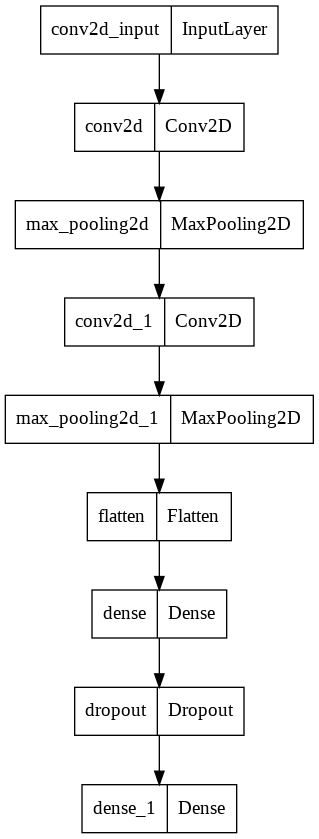

In [ ]:
keras.utils.plot_model(model)

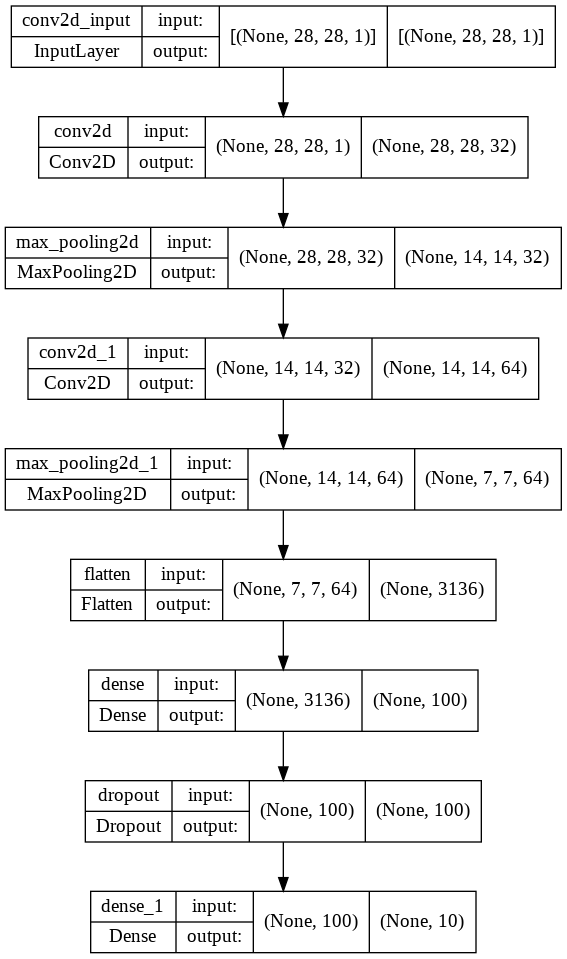

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

# Compile and Fit

In [ ]:
# optimizer: adam
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

# callback and early stopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 65s 43ms/step - loss: 0.5331 - accuracy: 0.8090 - val_loss: 0.3290 - val_accuracy: 0.8807
Epoch 2/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.3533 - accuracy: 0.8729 - val_loss: 0.2771 - val_accuracy: 0.8973
Epoch 3/20
1500/1500 [==============================] - 64s 43ms/step - loss: 0.3032 - accuracy: 0.8901 - val_loss: 0.2525 - val_accuracy: 0.9049
Epoch 4/20
1500/1500 [==============================] - 64s 43ms/step - loss: 0.2691 - accuracy: 0.9030 - val_loss: 0.2521 - val_accuracy: 0.9081
Epoch 5/20
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2445 - accuracy: 0.9096 - val_loss: 0.2351 - val_accuracy: 0.9107
Epoch 6/20
1500/1500 [==============================] - 66s 44ms/step - loss: 0.2262 - accuracy: 0.9150 - val_loss: 0.2259 - val_accuracy: 0.9162
Epoch 7/20
1500/1500 [==============================] - 65s 43ms/step - loss: 0.2075 - accuracy: 0.9229 - val_loss: 0.2284 -

# Validation and Predict

- loss function (visualize train loss and validation loss)

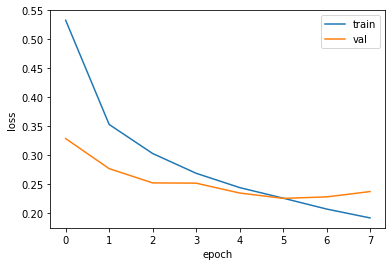

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'val'])
plt.show()

- The epoch 6 appears to be optimal.

In [ ]:
model.evaluate(val_scaled, val_target) # same as output of epoch 6

375/375 [==============================] - 5s 12ms/step - loss: 0.2259 - accuracy: 0.9162


[0.22585801780223846, 0.9161666631698608]

- Confirm prediction of the first sample

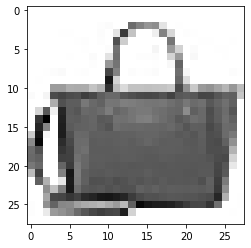

In [ ]:
fig, ax = plt.subplots()
ax.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

In [ ]:
# The fit(), predict(), and evaluate() all expect the first dimension of the input to be the batch dimension.
# Slicing, unlike indexing, maintains the entire dimension even if there is one element.
preds = model.predict(val_scaled[0:1])
print(preds)

[[1.88540562e-13 1.07813886e-17 3.65283819e-17 1.44768129e-14
  7.86518068e-17 2.58884016e-15 2.82545543e-15 2.49630367e-13
  1.00000000e+00 1.07822686e-14]]


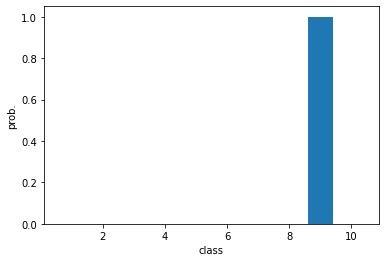

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(1,11),preds[0])
ax.set_xlabel('class')
ax.set_ylabel('prob.')
plt.show()

In [ ]:
classes = ['t-shirt', 'pants', 'sweater', 'dress', 'coat', 'sandal',
           'shirt', 'sneakers', 'bag', 'boots']

import numpy as np
print(classes[np.argmax(preds)])

bag


# Model Test

In [ ]:
test_scaled = test_input.reshape(-1,28,28,1)/255.0
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 4s 13ms/step - loss: 0.2519 - accuracy: 0.9093


[0.25190481543540955, 0.9093000292778015]

# GPU check in Google Colab

In [ ]:
'''
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''

In [ ]:
'''
import tensorflow as tf
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

with tf.device('/device:GPU:0'):
  history = model.fit(train_scaled, train_target, epochs=10,
                      validation_data=(val_scaled, val_target),
                      callbacks=[checkpoint_cb, early_stopping_cb])
'''

# Visualize CNN

In [ ]:
model = keras.models.load_model('best-cnn-model.h5')
model.layers

- check weights of the first convolution layer

In [ ]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


In [ ]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.010425919 0.21259554


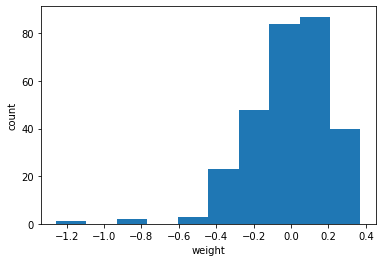

In [ ]:
fig, ax = plt.subplots()
ax.hist(conv_weights.reshape(-1,1))
ax.set_xlabel('weight')
ax.set_ylabel('count')
plt.show()

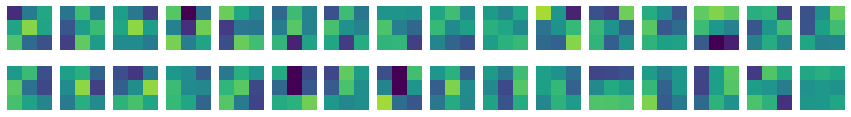

In [ ]:
# 32 kernels of 3*3 size
fig, ax = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
  for j in range(16):
    ax[i,j].imshow(conv_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
    ax[i,j].axis('off')
plt.show()

- Compare to empty CNN which is untrained 

In [ ]:
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                          padding='same', input_shape=(28,28,1)))
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [ ]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

-0.008161874 0.08076286


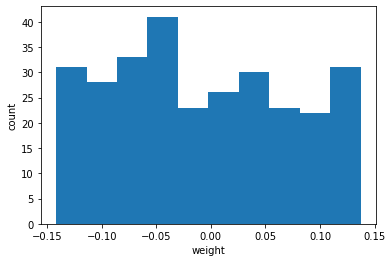

In [ ]:
fig, ax = plt.subplots()
ax.hist(no_training_weights.reshape(-1,1))
ax.set_xlabel('weight')
ax.set_ylabel('count')
plt.show()

- It shows a relatively even distribution<br/>because tensorflow randomly select a value from an equal distribution at first.

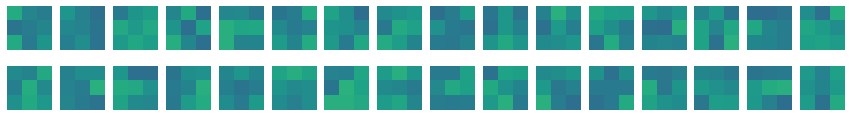

In [ ]:
fig, ax = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
  for j in range(16):
    ax[i,j].imshow(no_training_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
    ax[i,j].axis('off')
plt.show()

# Visualize Feature Map

- feature map of the first convolution layer

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


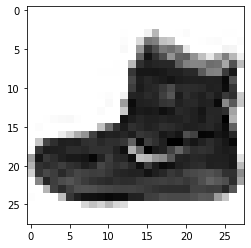

In [ ]:
print(model.input)
conv_acti = keras.Model(model.input, model.layers[0].output) # functional API
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [ ]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1)/255.0
feature_maps = conv_acti.predict(inputs)
print(feature_maps.shape)

(1, 28, 28, 32)


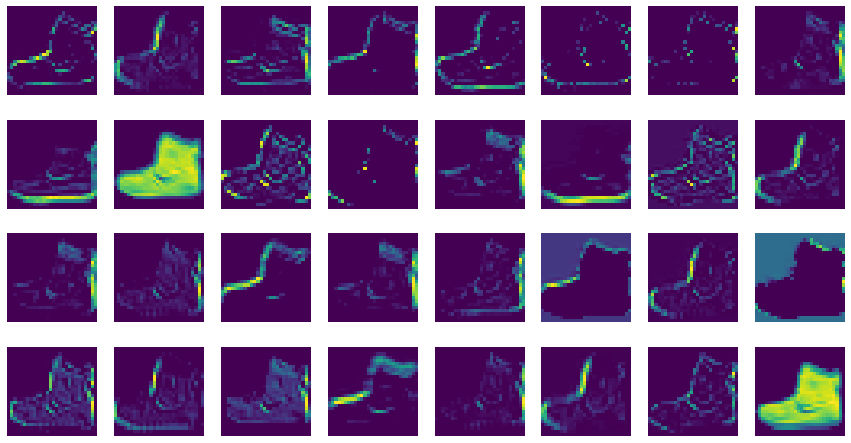

In [ ]:
fig, ax = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
  for j in range(8):
    ax[i,j].imshow(feature_maps[0,:,:,i*8+j])
    ax[i,j].axis('off')
plt.show()

- feature map of the second convolution layer

(1, 14, 14, 64)


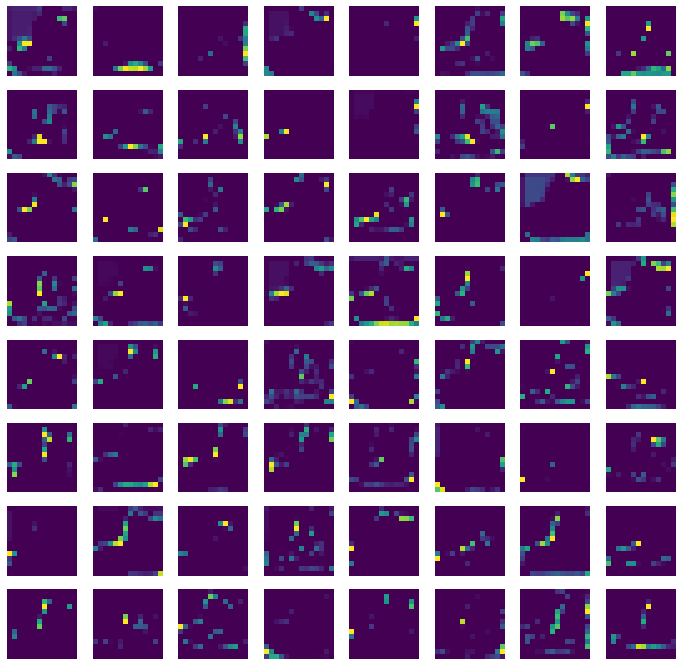

In [ ]:
conv2_acti = keras.Model(model.input, model.layers[2].output)
feature_maps = conv2_acti.predict(train_input[0:1].reshape(-1, 28, 28, 1)/255.0)
print(feature_maps.shape)

fig, axs = plt.subplots(8, 8, figsize=(12,12))

for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()